# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import IPython
import IPython.display
import tensorflow as tf
from keras.models import Model
import keras.layers as kl
import keras.activations as ka
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
random_seed = 123
SKIP_TIMESTEPS = 10
FORECAST_WINDOW = 10
FORECAST_SHIFT = 5
CONV_WIDTH = 5
TARGET_LABELS = ["ph", "temperature", "disolved_oxg"]

In [ ]:
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
f_path = "/content/drive/MyDrive/frefishparametersdataset/dataset/"
ponds = os.listdir(f_path)[:]
print(ponds)

# Loading and feature correcting Data

In [ ]:
def load_correct_data(ponds=ponds, skip_timesteps=SKIP_TIMESTEPS):
    data = []
    date_times = []
    used_ponds = []
    unused_ponds = []

    #loading data
    for pond in ponds:
        try:
            df = pd.read_csv(f_path + pond)
            df = df[::skip_timesteps]
            df["created_at"] = df["created_at"].apply(pd.to_datetime)
            date_time1 = pd.to_datetime(df.pop("created_at"), format="%Y-%m-%d %H:%M:%S")
            df.pop('population')
            df.pop('entry_id')
            for col in df.columns:
                col_mean = df[col].mean()
                df[col] = df[col].fillna(col_mean)
                if 'Unnamed' in col:
                    df.pop(col)

            data.append(df)
            date_times.append(date_time1)
            used_ponds.append(pond)
            IPython.display.clear_output()
        except:
            # print("\n\nERROR at POND: ", pond)
            unused_ponds.append(pond)

    #correcting data
    for df in data:
        df['temperature'].loc[df['temperature'] < 20] = 20
        df['ph'].loc[df['ph'] > 12] = 12
        df['ph'].loc[df['ph'] < 5] = 5
        df['ammonia'].loc[df['ammonia'] > 10] = 10
        df['nitrate'].loc[df['nitrate'] > 2000] = 2000
        IPython.display.clear_output()

    return (data, date_times, used_ponds, unused_ponds)

# Standarizing and Normalizing data

In [ ]:
def standarize_normalize(df):
    df_cols = df.columns
    standarizer = StandardScaler()
    normalizer = MinMaxScaler()

    df = normalizer.fit_transform(df)
    df = standarizer.fit_transform(df)

    df = pd.DataFrame(df, columns=df_cols)

    return df, normalizer, standarizer

In [ ]:
def compute_metrics(df):
    df_mean = df.mean()
    df_std = df.std()
    df_max = df.max()
    df_min = df.min()
    return df_mean, df_std, df_max, df_min

In [ ]:
def destandarize_denormalize(df, transformations):
    normalizer, standarizer = transformations
    df_cols = df.columns
    df = standarizer.inverse_transform(df)
    df = normalizer.inverse_transform(df)
    df = pd.DataFrame(df, columns=df_cols)

    return df

# Visualization tools

In [ ]:
def visualize_feature(feature_idx, data, date_times, used_ponds):

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    for i, df in enumerate(data):
        row_idx = i // 2
        col_idx = i % 2

        test_feature = df.columns[feature_idx]
        treshold0 = np.percentile(df[test_feature], 20)
        treshold1 = np.percentile(df[test_feature], 50)
        treshold2 = np.percentile(df[test_feature], 75)
        treshold3 = np.percentile(df[test_feature], 90)
        axs[row_idx, col_idx].plot(date_times[i], df[test_feature])
        axs[row_idx, col_idx].axhline(treshold0, color="black")
        axs[row_idx, col_idx].axhline(treshold1, color="green")
        axs[row_idx, col_idx].axhline(treshold2, color="yellow")
        axs[row_idx, col_idx].axhline(treshold3, color="red")
        axs[row_idx, col_idx].set_title(used_ponds[i] + f"[{treshold0:.2f} {treshold3:.2f}]")

        fig.suptitle(test_feature)
    plt.show()

In [ ]:
def visualize_df(df_idx, data, date_times):
    df = data[df_idx]
    date_time = date_times[df_idx]
    plot_cols = df.columns

    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']

    plot_features = df[plot_cols]
    plot_features.index = date_time

    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    for i, col in enumerate(plot_features):
        row_idx = i // 2
        col_idx = i % 2
        axs[row_idx, col_idx].plot(plot_features[col], color=colors[i], label=col)
        axs[row_idx, col_idx].tick_params(axis='x', labelsize=7)
        axs[row_idx, col_idx].legend()

    plt.show()

In [ ]:
def plot_history(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Training', 'Evaluation'])
    plt.title("Loss")
    plt.show()

# splitting the data

In [ ]:
def split_data(data, train_ratio=0.8, val_ratio=0.9):
    train_data = []
    val_data = []
    test_data = []
    for df in data:
        n = len(df)
        train_data.append(df[0:int(n*train_ratio)])
        val_data.append(df[int(n*train_ratio):int(n*val_ratio)])
        test_data.append(df[int(n*val_ratio):])

    return train_data, val_data, test_data

# Window Maker Class

In [ ]:
#from TensorFlow
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_data, val_data, test_data,
               label_columns=None):
    # Store the raw data.
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_data[0].columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col=TARGET_LABELS[0], max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue


      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      #plt.ylim((-3, 3))

      if n == 0:
        plt.legend()

    plt.xlabel(plot_col)



  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    full_dataset = None
    for i in range(len(self.train_data)):
      if i == 0:
        full_dataset = self.make_dataset(self.train_data[0])
      else:
        full_dataset = full_dataset.concatenate( self.make_dataset(self.train_data[i]))

    return full_dataset

  @property
  def val(self):
    full_dataset = None
    for i in range(len(self.val_data)):
      if i == 0:
        full_dataset = self.make_dataset(self.val_data[0])
      else:
        full_dataset = full_dataset.concatenate( self.make_dataset(self.val_data[i]))

    return full_dataset

  @property
  def test(self):
    full_dataset = None
    for i in range(len(self.test_data)):
      if i == 0:
        full_dataset = self.make_dataset(self.test_data[0])
      else:
        full_dataset = full_dataset.concatenate( self.make_dataset(self.test_data[i]))

    return full_dataset

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


# Pipeline

In [ ]:
#loading and preprocessing the data the data
data, date_times, used_ponds, unused_ponds = load_correct_data()

In [ ]:
print(used_ponds)

['data3.csv', 'data4.csv', 'data2.csv', 'data1.csv']


In [ ]:
data[0].head()

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
0,23.7500,80,27.736,7.04911,5.15546,114,6.74,3.2
10,23.6875,80,1.303,7.08542,5.82565,112,6.74,3.2
20,23.6875,80,1.633,7.07181,5.75912,112,6.74,3.2
30,23.6875,80,2.303,7.08542,5.89298,112,6.74,3.2
40,23.6875,80,24.879,7.08996,6.05327,115,6.74,3.2


In [ ]:
#normalizing and standarizing the data based on whole dataset
full_data = pd.concat(data)
full_data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
temperature,51437.0,24.490289,0.869715,20.000,23.87500,24.43750,25.06250,27.750
turbidity,51437.0,88.870871,22.803931,1.000,91.00000,100.00000,100.00000,100.000
disolved_oxg,51437.0,9.094743,9.694237,0.008,3.20000,5.08000,10.33700,41.109
ph,51437.0,7.073047,0.991155,5.000,7.11720,7.31694,7.57569,12.000
ammonia,51437.0,6.174178,4.466590,0.000,0.45842,10.00000,10.00000,10.000
nitrate,51437.0,654.169606,496.614447,45.000,159.00000,538.00000,972.00000,2000.000
fish_length,51437.0,18.803939,7.796342,6.740,13.14000,17.54000,22.26000,35.390
fish_weight,51437.0,89.786810,107.681782,2.910,18.10000,46.50000,90.56000,394.660


In [ ]:
full_data, normalizer, standarizer = standarize_normalize(full_data)
full_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,51437.0,6.542237e-16,1.00001,-5.162991,-0.707467,-0.060698,0.657935,3.748056
turbidity,51437.0,2.188113e-16,1.00001,-3.853359,0.093368,0.488040,0.488040,0.488040
disolved_oxg,51437.0,-7.514732e-17,1.00001,-0.937344,-0.608073,-0.414141,0.128145,3.302433
ph,51437.0,1.265348e-16,1.00001,-2.091568,0.044547,0.246072,0.507133,4.970971
ammonia,51437.0,1.856581e-16,1.00001,-1.382316,-1.279682,0.856550,0.856550,0.856550
nitrate,51437.0,-2.652258e-17,1.00001,-1.226657,-0.997100,-0.233925,0.640000,2.710037
fish_length,51437.0,-1.149312e-16,1.00001,-1.547400,-0.726494,-0.162121,0.443297,2.127436
fish_weight,51437.0,8.509328e-17,1.00001,-0.806800,-0.665735,-0.401992,0.007180,2.831270


## normalizing and standarizing each dataset

In [ ]:
for i in range(len(data)):
    df_cols = data[i].columns
    data[i] = normalizer.transform(data[i])
    data[i] = standarizer.transform(data[i])

    data[i] = pd.DataFrame(data[i], columns=df_cols)

In [ ]:
data[0].head()

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
0,-0.851194,-0.38901,1.922940,-0.024151,-0.228077,-1.087715,-1.5474,-0.804107
1,-0.923057,-0.38901,-0.803758,0.012483,-0.078031,-1.091742,-1.5474,-0.804107
2,-0.923057,-0.38901,-0.769717,-0.001248,-0.092926,-1.091742,-1.5474,-0.804107
3,-0.923057,-0.38901,-0.700603,0.012483,-0.062957,-1.091742,-1.5474,-0.804107
4,-0.923057,-0.38901,1.628226,0.017064,-0.027070,-1.085701,-1.5474,-0.804107


In [ ]:
#testing getting data back to original
# for i, df in enumerate(data):
#     data[i] = destandarize_denormalize(df, transformations[i])

# data[0].head()

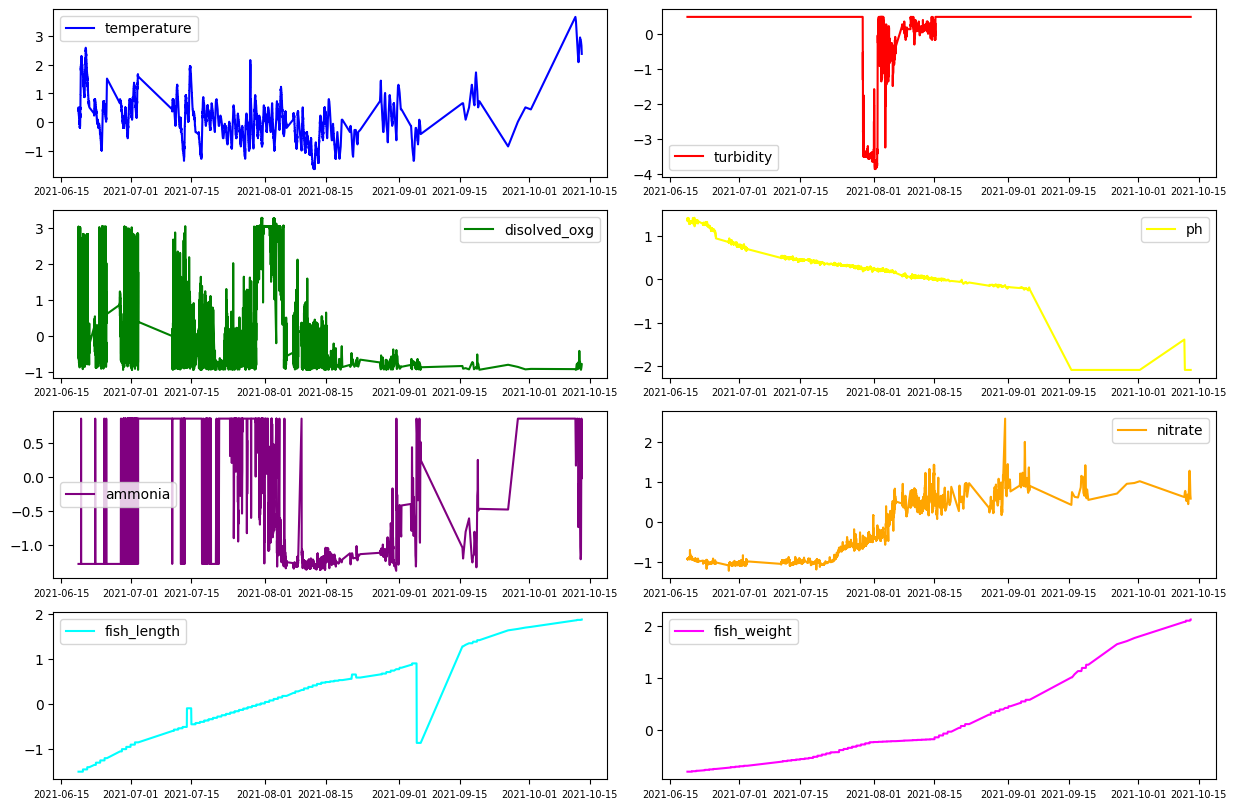

In [ ]:
#visualizing a dataframe
visualize_df(3, data, date_times)

In [ ]:
#splitting the dataset into train, val, test sets
train_data, val_data, test_data = split_data(data)

In [ ]:
column_indices = {name: i for i, name in enumerate(data[0].columns)}
column_indices

{'temperature': 0,
 'turbidity': 1,
 'disolved_oxg': 2,
 'ph': 3,
 'ammonia': 4,
 'nitrate': 5,
 'fish_length': 6,
 'fish_weight': 7}

In [ ]:
del data
del date_times
gc.collect()

26514

# Creating Conv Model

In [ ]:
#generating a window
window_cnn = WindowGenerator(input_width=FORECAST_WINDOW+2, label_width=FORECAST_WINDOW, shift=FORECAST_SHIFT,
                             train_data=train_data, val_data=val_data, test_data=test_data, label_columns=TARGET_LABELS)
window_cnn

Total window size: 17
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 7  8  9 10 11 12 13 14 15 16]
Label column name(s): ['ph', 'temperature', 'disolved_oxg']

In [ ]:
for example_inputs, example_labels in window_cnn.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 8)
Labels shape (batch, time, features): (32, 10, 3)


In [ ]:
def create_conv_model(input_shape=(FORECAST_WINDOW+2, 8)):
    inputs = kl.Input(shape=input_shape)
    conv1 = kl.Conv1D(filters=64, kernel_size=CONV_WIDTH, strides=1, activation="selu", padding="same")(inputs)
    pool1 = kl.MaxPool1D(pool_size=3, strides=1)(conv1)
    conv3 = kl.Conv1D(filters=128, kernel_size=3, strides=1, activation="selu", padding="same")(pool1)
    dense1 = kl.Dense(units=64)(conv3)
    dense1 = kl.PReLU()(dense1)
    dense1 = kl.Dropout(rate=0.3)(dense1)
    dense2 = kl.Dense(units=16)(dense1)
    dense2 = kl.PReLU()(dense2)
    dense2 = kl.Dropout(rate=0.3)(dense2)
    outputs = kl.Dense(units=len(TARGET_LABELS))(dense2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [ ]:
conv_model = create_conv_model()
conv_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 12, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 12, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 10, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_8 (PReLU)                    │ (None, 10, 64)              │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10, 16)              │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_9 (PReLU)                    │ (None, 10, 16)              │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10, 3)               │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,475 (146.39 KB)

 Trainable params: 37,475 (146.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2)
history = conv_model.fit(window_cnn.train, epochs=10, validation_data=window_cnn.val, callbacks=[reduce_lr])

Epoch 1/10
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.2498 - mean_absolute_error: 0.3229 - val_loss: 0.1470 - val_mean_absolute_error: 0.2907 - learning_rate: 0.0010
Epoch 2/10
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1898 - mean_absolute_error: 0.2700 - val_loss: 0.1226 - val_mean_absolute_error: 0.2640 - learning_rate: 0.0010
Epoch 3/10
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.1849 - mean_absolute_error: 0.2655 - val_loss: 0.1282 - val_mean_absolute_error: 0.2638 - learning_rate: 0.0010
Epoch 4/10
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1820 - mean_absolute_error: 0.2617 - val_loss: 0.1467 - val_mean_absolute_error: 0.2598 - learning_rate: 0.0010
Epoch 5/10
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.1899 - mean_absolute_error: 0.2744 - val_loss: 0.0555 - val_mean_absolute_error: 0.1740 - learning_rate: 1.0000e-04
Epoch 6/10
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1839 - mean_absolute_error: 0.2692 - val

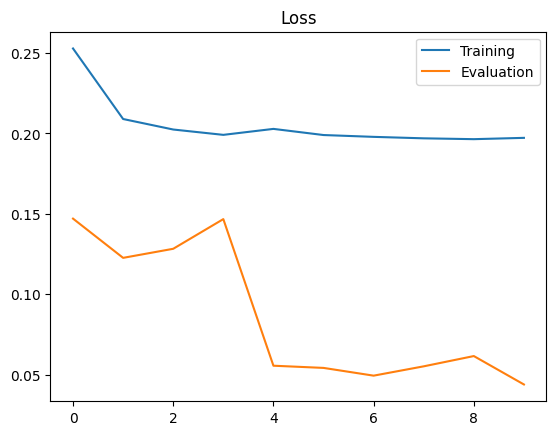

In [ ]:
plot_history(history.history)

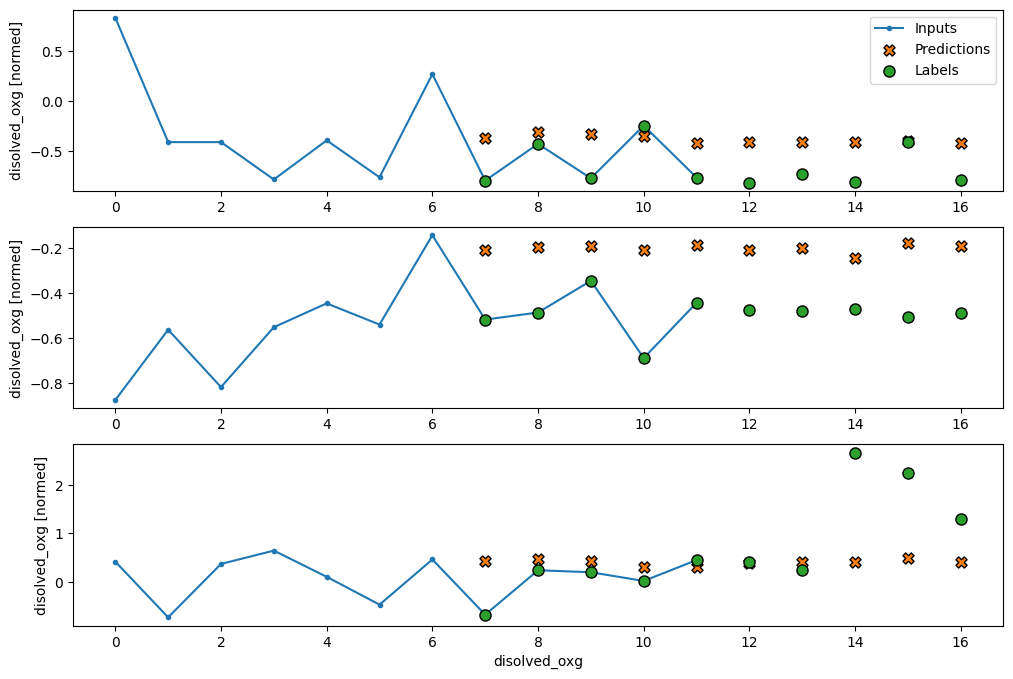

In [ ]:
window_cnn.plot(conv_model, plot_col=TARGET_LABELS[2])

In [ ]:
val_MSE_cnn = conv_model.evaluate(window_cnn.val)[0]
test_MSE_cnn = conv_model.evaluate(window_cnn.test)[0]

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0403 - mean_absolute_error: 0.1479
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0969 - mean_absolute_error: 0.1716


# Deep LSTM Model

In [ ]:
#generating a window
window_rnn = WindowGenerator(input_width=FORECAST_WINDOW, label_width=FORECAST_WINDOW, shift=FORECAST_SHIFT,
                              train_data=train_data, val_data=val_data, test_data=test_data, label_columns=TARGET_LABELS)
window_rnn

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['ph', 'temperature', 'disolved_oxg']

In [ ]:
for example_inputs, example_labels in window_rnn.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 8)
Labels shape (batch, time, features): (32, 10, 3)


In [ ]:
def create_rnn_model(input_shape=(FORECAST_WINDOW, 8)):
    inputs = kl.Input(shape=input_shape)

    rnn1 = kl.LSTM(units=64, activation="relu", return_sequences=True)(inputs)
    rnn1 = kl.Dropout(rate=0.3)(rnn1)
    rnn2 = kl.LSTM(units=32, activation="relu", return_sequences=True)(rnn1)
    rnn2 = kl.Dropout(rate=0.2)(rnn2)
    dense1 = kl.Dense(units=16)(rnn2)
    dense1 = kl.PReLU()(dense1)
    dense1 = kl.Dropout(rate=0.2)(dense1)
    outputs = kl.Dense(units=len(TARGET_LABELS))(dense1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [ ]:
rnn_model = create_rnn_model()
rnn_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 10, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10, 16)              │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_10 (PReLU)                   │ (None, 10, 16)              │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10, 3)               │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,843 (124.39 KB)

 Trainable params: 31,843 (124.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2)
history1 = rnn_model.fit(window_rnn.train, epochs=2, validation_data=window_rnn.val, callbacks=[reduce_lr])

Epoch 1/2
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2677 - mean_absolute_error: 0.3359 - val_loss: 0.1709 - val_mean_absolute_error: 0.3036 - learning_rate: 0.0010
Epoch 2/2
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - loss: 0.1901 - mean_absolute_error: 0.2695 - val_loss: 0.1515 - val_mean_absolute_error: 0.2767 - learning_rate: 0.0010


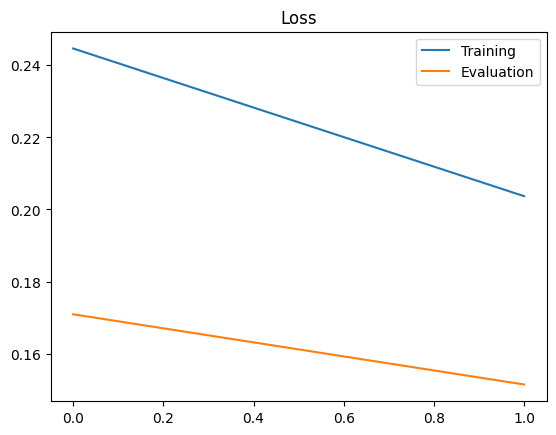

In [ ]:
plot_history(history1.history)

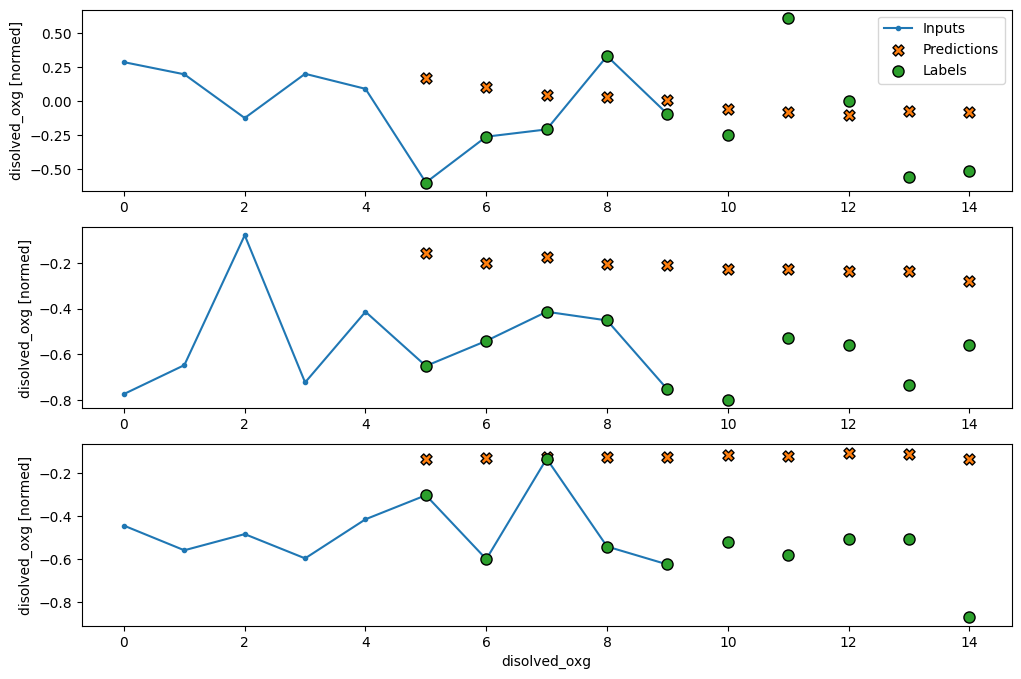

In [ ]:
window_rnn.plot(rnn_model, plot_col=TARGET_LABELS[2])

In [ ]:
val_MSE_lstm = rnn_model.evaluate(window_rnn.val)[0]
test_MSE_lstm = rnn_model.evaluate(window_rnn.test)[0]

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0961 - mean_absolute_error: 0.2203
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2054 - mean_absolute_error: 0.3021


# GRU simple RNN

In [ ]:
window_gru = WindowGenerator(input_width=FORECAST_WINDOW, label_width=FORECAST_WINDOW, shift=FORECAST_SHIFT,
                              train_data=train_data, val_data=val_data, test_data=test_data, label_columns=TARGET_LABELS)
window_gru

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['ph', 'temperature', 'disolved_oxg']

In [ ]:
for example_inputs, example_labels in window_gru.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 8)
Labels shape (batch, time, features): (32, 10, 3)


In [ ]:
def create_gru_model(input_shape=(FORECAST_WINDOW, 8)):
    inputs = kl.Input(shape=input_shape)

    rnn1 = kl.GRU(units=96, activation="relu", return_sequences=True)(inputs)
    rnn1 = kl.Dropout(rate=0.3)(rnn1)
    dense1 = kl.Dense(units=32)(rnn1)
    dense1 = kl.PReLU()(dense1)
    dense1 = kl.Dropout(rate=0.3)(dense1)

    dense2 = kl.Dense(units=16)(dense1)
    dense2 = kl.PReLU()(dense2)
    dense2 = kl.Dropout(rate=0.2)(dense2)

    outputs = kl.Dense(units=len(TARGET_LABELS))(dense2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [ ]:
gru_model = create_gru_model()
gru_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 10, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10, 96)              │          30,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 10, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_11 (PReLU)                   │ (None, 10, 32)              │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10, 16)              │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_12 (PReLU)                   │ (None, 10, 16)              │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10, 3)               │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,691 (135.51 KB)

 Trainable params: 34,691 (135.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2)
history2 = gru_model.fit(window_gru.train, epochs=2, validation_data=window_gru.val, callbacks=[reduce_lr])

Epoch 1/2
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.2679 - mean_absolute_error: 0.3387 - val_loss: 0.1326 - val_mean_absolute_error: 0.2700 - learning_rate: 0.0010
Epoch 2/2
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.1918 - mean_absolute_error: 0.2704 - val_loss: 0.1060 - val_mean_absolute_error: 0.2333 - learning_rate: 0.0010


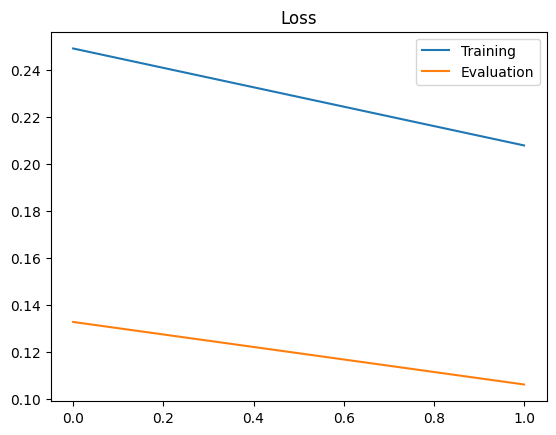

In [ ]:
plot_history(history2.history)

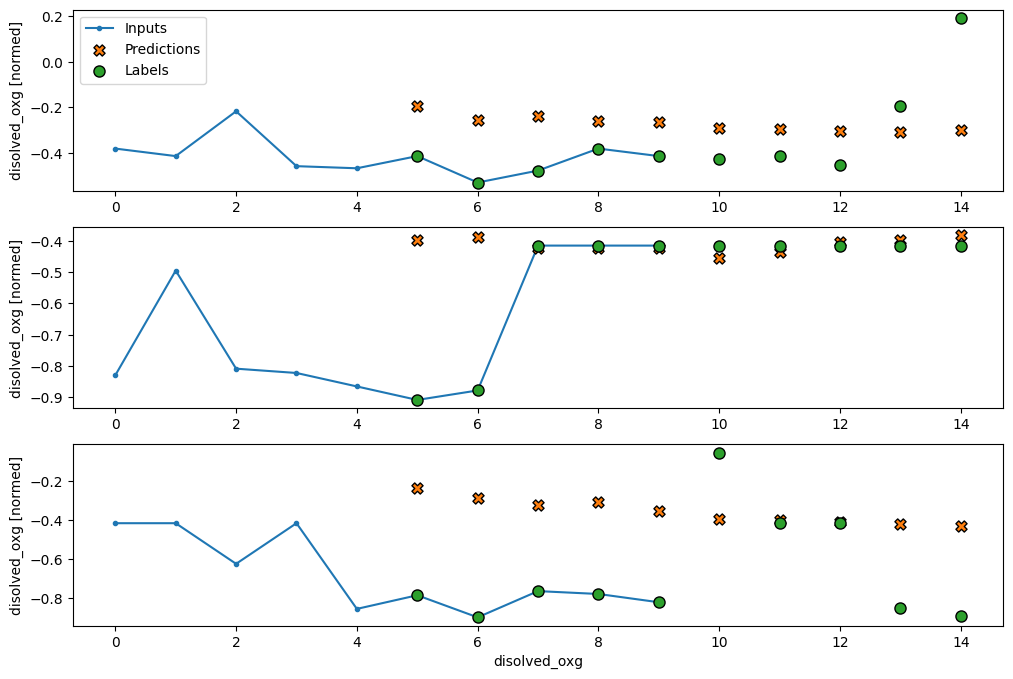

In [ ]:
window_gru.plot(gru_model, plot_col=TARGET_LABELS[2])

In [ ]:
val_MSE_gru = gru_model.evaluate(window_gru.val)[0]
test_MSE_gru = gru_model.evaluate(window_gru.test)[0]

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0750 - mean_absolute_error: 0.2060
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1637 - mean_absolute_error: 0.2690


# Fully Connected NN

In [ ]:
window_nn = WindowGenerator(input_width=FORECAST_WINDOW, label_width=FORECAST_WINDOW, shift=FORECAST_SHIFT,
                             train_data=train_data, val_data=val_data, test_data=test_data, label_columns=TARGET_LABELS)
window_nn

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['ph', 'temperature', 'disolved_oxg']

In [ ]:
for example_inputs, example_labels in window_nn.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 8)
Labels shape (batch, time, features): (32, 10, 3)


In [ ]:
def create_nn_model(input_shape=(FORECAST_WINDOW, 8)):
    inputs = kl.Input(shape=input_shape)

    dense1 = kl.Dense(units=256)(inputs)
    dense1 = kl.PReLU()(dense1)
    dense1 = kl.Dropout(rate=0.3)(dense1)

    dense2 = kl.Dense(units=64)(dense1)
    dense2 = kl.PReLU()(dense2)
    dense2 = kl.Dropout(rate=0.2)(dense2)

    dense3 = kl.Dense(units=16)(dense2)
    dense3 = kl.PReLU()(dense3)
    dense3 = kl.Dropout(rate=0.2)(dense3)

    outputs = kl.Dense(units=len(TARGET_LABELS))(dense3)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [ ]:
nn_model = create_nn_model()
nn_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 10, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10, 256)             │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_13 (PReLU)                   │ (None, 10, 256)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_14 (PReLU)                   │ (None, 10, 64)              │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10, 16)              │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_15 (PReLU)                   │ (None, 10, 16)              │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 10, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10, 3)               │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,203 (90.64 KB)

 Trainable params: 23,203 (90.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2)
history3 = nn_model.fit(window_nn.train, epochs=2, validation_data=window_nn.val, callbacks=[reduce_lr])

Epoch 1/2
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.2265 - mean_absolute_error: 0.3024 - val_loss: 0.0744 - val_mean_absolute_error: 0.2106 - learning_rate: 0.0010
Epoch 2/2
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1820 - mean_absolute_error: 0.2529 - val_loss: 0.1063 - val_mean_absolute_error: 0.2480 - learning_rate: 0.0010


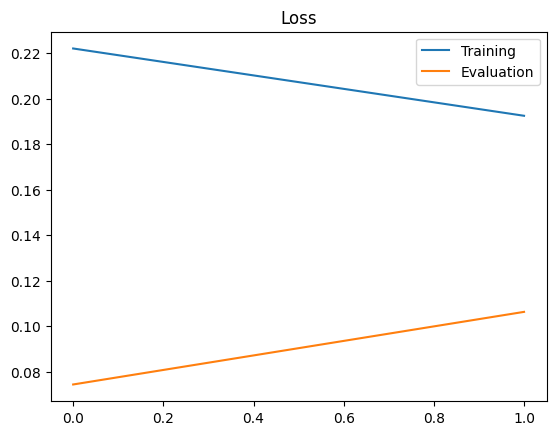

In [ ]:
plot_history(history3.history)

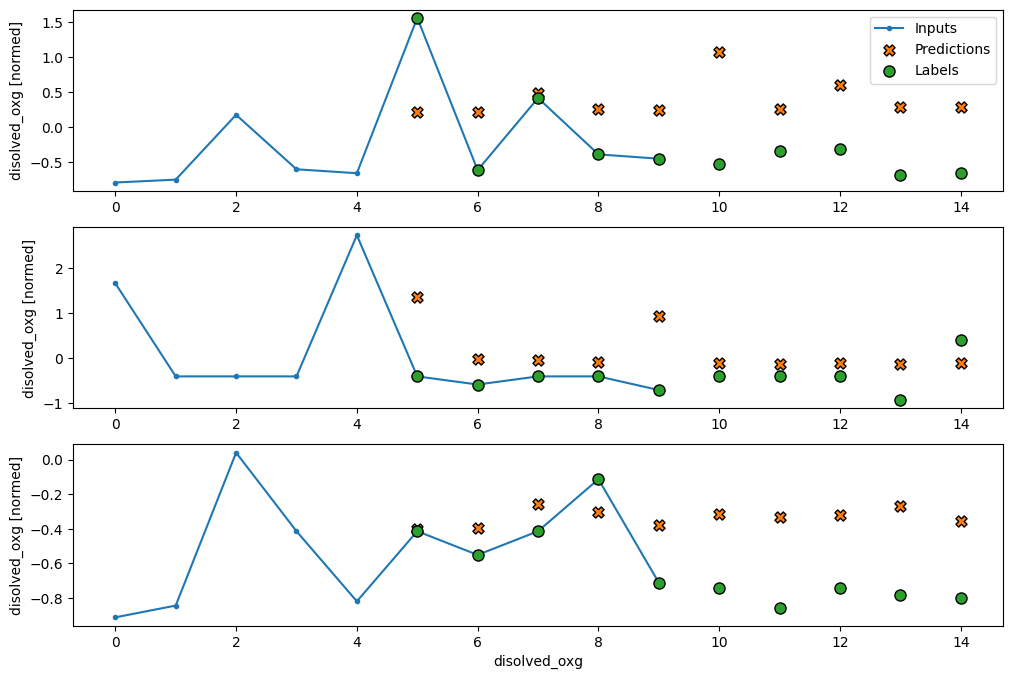

In [ ]:
window_nn.plot(nn_model, plot_col=TARGET_LABELS[2])

In [ ]:
val_MSE_nn = nn_model.evaluate(window_nn.val)[0]
test_MSE_nn = nn_model.evaluate(window_nn.test)[0]

161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0703 - mean_absolute_error: 0.2019
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1517 - mean_absolute_error: 0.2603


In [ ]:
val_MSE_nn

0.10626698285341263

# Comparaison Between all Models

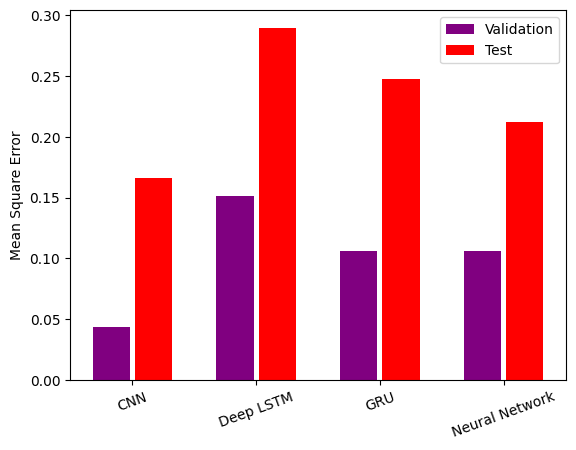

In [ ]:

labels = ['CNN', 'Deep LSTM', 'GRU', 'Neural Network']
performances_val = [val_MSE_cnn,val_MSE_lstm, val_MSE_gru, val_MSE_nn]
performaces_test = [test_MSE_cnn,test_MSE_lstm, test_MSE_gru, test_MSE_nn]

x = np.arange(len(performances_val))
width = 0.3

plt.ylabel('Mean Square Error')
plt.bar(x - 0.17, performances_val, width, label='Validation', color="purple")
plt.bar(x + 0.17, performaces_test, width, label='Test', color="red")
plt.xticks(ticks=x, labels=labels,
           rotation=20)
_ = plt.legend()
plt.show()

# Save Models

In [ ]:
# conv_model.save("CNN_model.tf")
#rnn_model.save("LSTM_model.tf")
# gru_model.save("GRU_model.tf")
# nn_model.save("NN_model.tf")